In [ ]:
!pip3 install mxnet --quiet
!pip install gluonts --quiet
!pip install plotly --upgrade

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (5.1.0)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import plotly.express as px
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.model import deepar
from gluonts.dataset import common
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator
from gluonts.evaluation import make_evaluation_predictions

plt.rcParams["figure.figsize"] = (10,8)

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


#DelhiDataClimate

In [ ]:
df=pd.read_csv('DailyDelhiClimateTrain.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


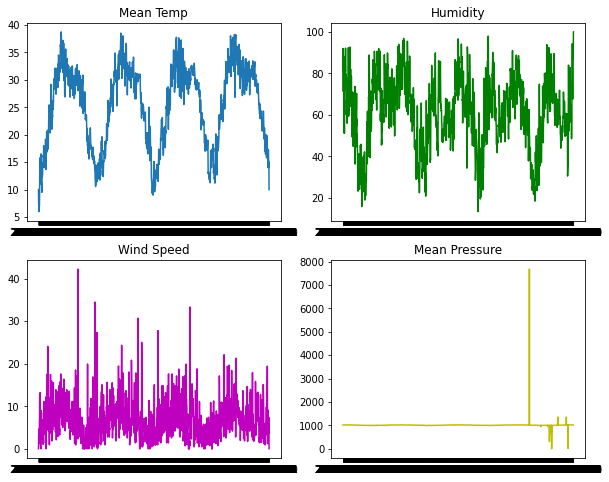

In [ ]:
df.set_index('date',inplace=True)
figure, axis = plt.subplots(2, 2)
axis[0,0].plot(df['meantemp'])
axis[0,0].set_title('Mean Temp')
axis[0,1].plot(df['humidity'], 'g')
axis[0,1].set_title('Humidity')
axis[1,0].plot(df['wind_speed'], 'm')
axis[1,0].set_title('Wind Speed')
axis[1,1].plot(df['meanpressure'], 'y')
axis[1,1].set_title('Mean Pressure')
plt.show()

## Prediction for Meanteamp

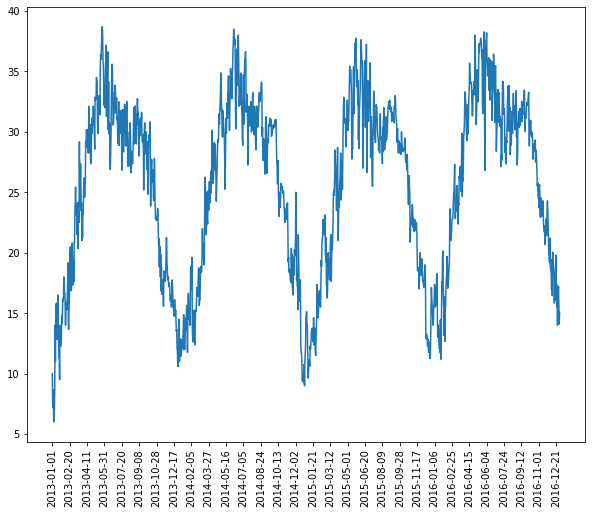

In [ ]:
df=pd.read_csv('DailyDelhiClimateTrain.csv')
df=df.iloc[:-1,:2]
df.set_index('date',inplace=True)
plt.plot(df)
plt.xticks(np.arange(0, len(df)+1, 50),rotation=90)
plt.show()

In [ ]:
test_df = pd.read_csv('DailyDelhiClimateTest.csv')
test_df = test_df.iloc[:,:2]
test_df.set_index('date',inplace=True)

In [ ]:
data = common.ListDataset([{
    "start": df.index[0],
    "target": df.meantemp
}],freq="1D")

test_data = common.ListDataset(
    [{"start": test_df.index[0], "target": test_df.meantemp}],
    freq = "1D"
)

concat_df = pd.concat([df,test_df])
concat_data = common.ListDataset(
    [{"start": concat_df.index[0], "target": concat_df.meantemp}],
    freq = "1D"
)

In [ ]:
trainer = Trainer(epochs=10)
estimator = deepar.DeepAREstimator(
    freq="1D", prediction_length=len(test_df), trainer=trainer)
predictor = estimator.train(training_data=data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:15<00:00,  3.19it/s, epoch=10/10, avg_epoch_loss=1.85]


In [ ]:
prediction = next(predictor.predict(data))

fig = px.line(y=prediction.mean,x=test_df.index)
fig.add_scatter(x=test_df.index,y=test_df['meantemp'])
fig.show()

In [ ]:
fig = px.line(x=concat_df.index,y=concat_df['meantemp'])
fig.add_scatter(y=prediction.mean,x=test_df.index)
fig.add_vrect(x0=test_df.index[0], x1=test_df.index[-1])
fig.show()

Forecast using GluonTS function

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=concat_data, 
    predictor=predictor,
    num_samples=len(test_df),  
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

ts_entry = tss[0]
forecast_entry = forecasts[0]

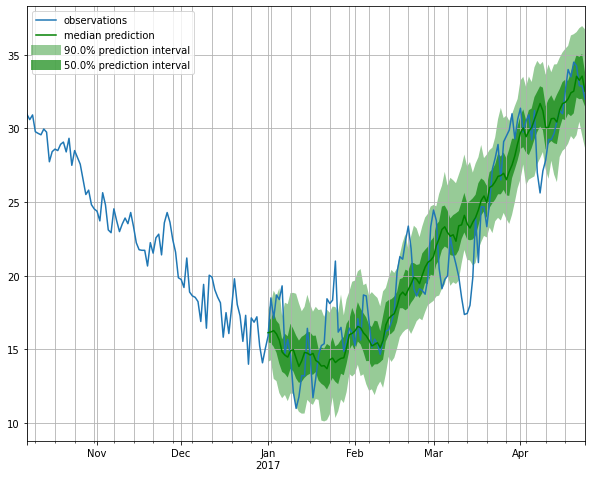

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 200
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    ts_entry[-plot_length:].plot()
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)

Evaluation

In [ ]:
evaluator = Evaluator([0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]


In [ ]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 5.978982490405702,
    "abs_error": 209.1842803955078,
    "abs_target_sum": 2475.291015625,
    "abs_target_mean": 21.713079084429825,
    "seasonal_error": 1.2366545376712328,
    "MASE": 1.483801475783365,
    "MAPE": 0.09176630722848993,
    "sMAPE": 0.09098846033999794,
    "OWA": NaN,
    "MSIS": 11.542232709043212,
    "QuantileLoss[0.5]": 209.1842679977417,
    "Coverage[0.5]": 0.49122807017543857,
    "QuantileLoss[0.9]": 95.99115734100342,
    "Coverage[0.9]": 0.8596491228070176,
    "RMSE": 2.4451957979690917,
    "NRMSE": 0.11261395900881284,
    "ND": 0.08450896443087105,
    "wQuantileLoss[0.5]": 0.08450895942226155,
    "wQuantileLoss[0.9]": 0.03877974619350609,
    "mean_absolute_QuantileLoss": 152.58771266937256,
    "mean_wQuantileLoss": 0.06164435280788382,
    "MAE_Coverage": 0.02456140350877195
}


In [ ]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,5.978982,209.18428,2475.291016,21.713079,1.236655,1.483801,0.091766,0.090988,NaN,11.542233,209.184268,0.491228,95.991157,0.859649


## Prediction for Humidity

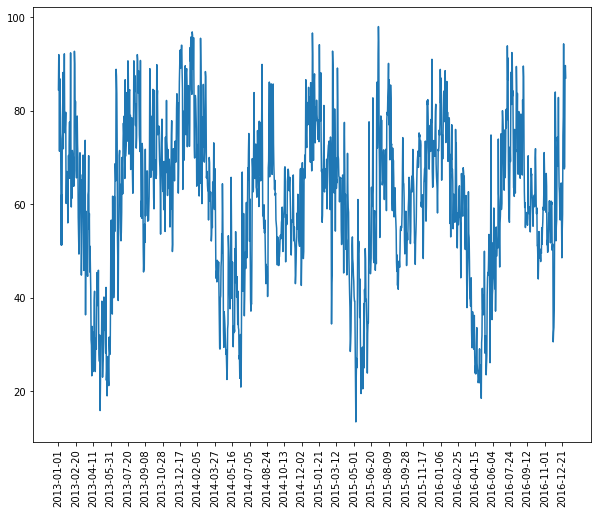

In [ ]:
df=pd.read_csv('DailyDelhiClimateTrain.csv')
df=df.iloc[:-1,[0,2]]
df.set_index('date',inplace=True)
plt.plot(df)
plt.xticks(np.arange(0, len(df)+1, 50),rotation=90)
plt.show()

In [ ]:
test_df = pd.read_csv('DailyDelhiClimateTest.csv')
test_df = test_df.iloc[:,[0,2]]
test_df.set_index('date',inplace=True)

In [ ]:
data = common.ListDataset([{
    "start": df.index[0],
    "target": df.humidity
}],freq="1D")


test_data = common.ListDataset(
    [{"start": test_df.index[0], "target": test_df.humidity}],
    freq = "1D"
)

concat_df = pd.concat([df,test_df])
concat_data = common.ListDataset(
    [{"start": concat_df.index[0], "target": concat_df.humidity}],
    freq = "1D"
)

In [ ]:
trainer = Trainer(epochs=10)
estimator = deepar.DeepAREstimator(
    freq="1D", prediction_length=len(test_df), trainer=trainer)
predictor = estimator.train(training_data=data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:16<00:00,  3.11it/s, epoch=10/10, avg_epoch_loss=3.36]


In [ ]:
prediction = next(predictor.predict(data))

fig = px.line(y=prediction.mean,x=test_df.index)
fig.add_scatter(x=test_df.index,y=test_df['humidity'])
fig.show()

In [ ]:
fig = px.line(x=concat_df.index,y=concat_df['humidity'])
fig.add_scatter(y=prediction.mean,x=test_df.index)
fig.add_vrect(x0=test_df.index[0], x1=test_df.index[-1])
fig.show()

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=concat_data,
    predictor=predictor,
    num_samples=len(test_df),
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

ts_entry = tss[0]
forecast_entry = forecasts[0]

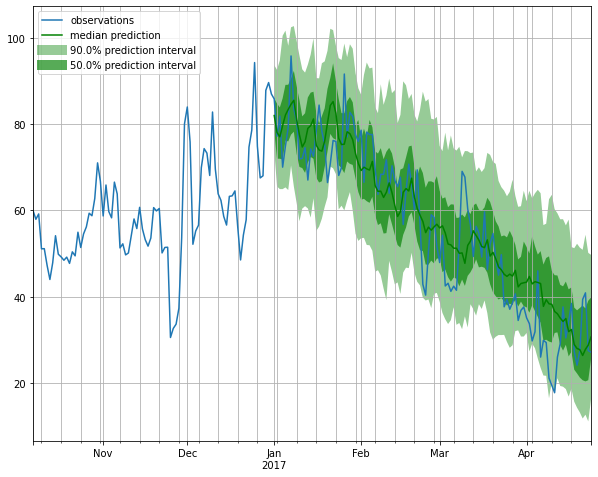

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 200
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    ts_entry[-plot_length:].plot()
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)

In [ ]:
evaluator = Evaluator(quantiles=[0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 20.05it/s]

{
    "MSE": 69.8905179207785,
    "abs_error": 767.17138671875,
    "abs_target_sum": 6413.45361328125,
    "abs_target_mean": 56.2583650287829,
    "seasonal_error": 6.135475973886987,
    "MASE": 1.096829911216321,
    "MAPE": 0.15137844754938493,
    "sMAPE": 0.13739059682477983,
    "OWA": NaN,
    "MSIS": 7.257827512024542,
    "QuantileLoss[0.5]": 767.1713981628418,
    "Coverage[0.5]": 0.6052631578947368,
    "QuantileLoss[0.9]": 420.8027072906493,
    "Coverage[0.9]": 0.9736842105263158,
    "RMSE": 8.360054899387833,
    "NRMSE": 0.1486010995006816,
    "ND": 0.1196190746792117,
    "wQuantileLoss[0.5]": 0.11961907646360004,
    "wQuantileLoss[0.9]": 0.06561249720731328,
    "mean_absolute_QuantileLoss": 593.9870527267456,
    "mean_wQuantileLoss": 0.09261578683545665,
    "MAE_Coverage": 0.08947368421052632
}


In [ ]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,69.890518,767.171387,6413.453613,56.258365,6.135476,1.09683,0.151378,0.137391,NaN,7.257828,767.171398,0.605263,420.802707,0.973684
